# py_f2recom overview
Moritz Zeising, moritz.zeising@awi.de

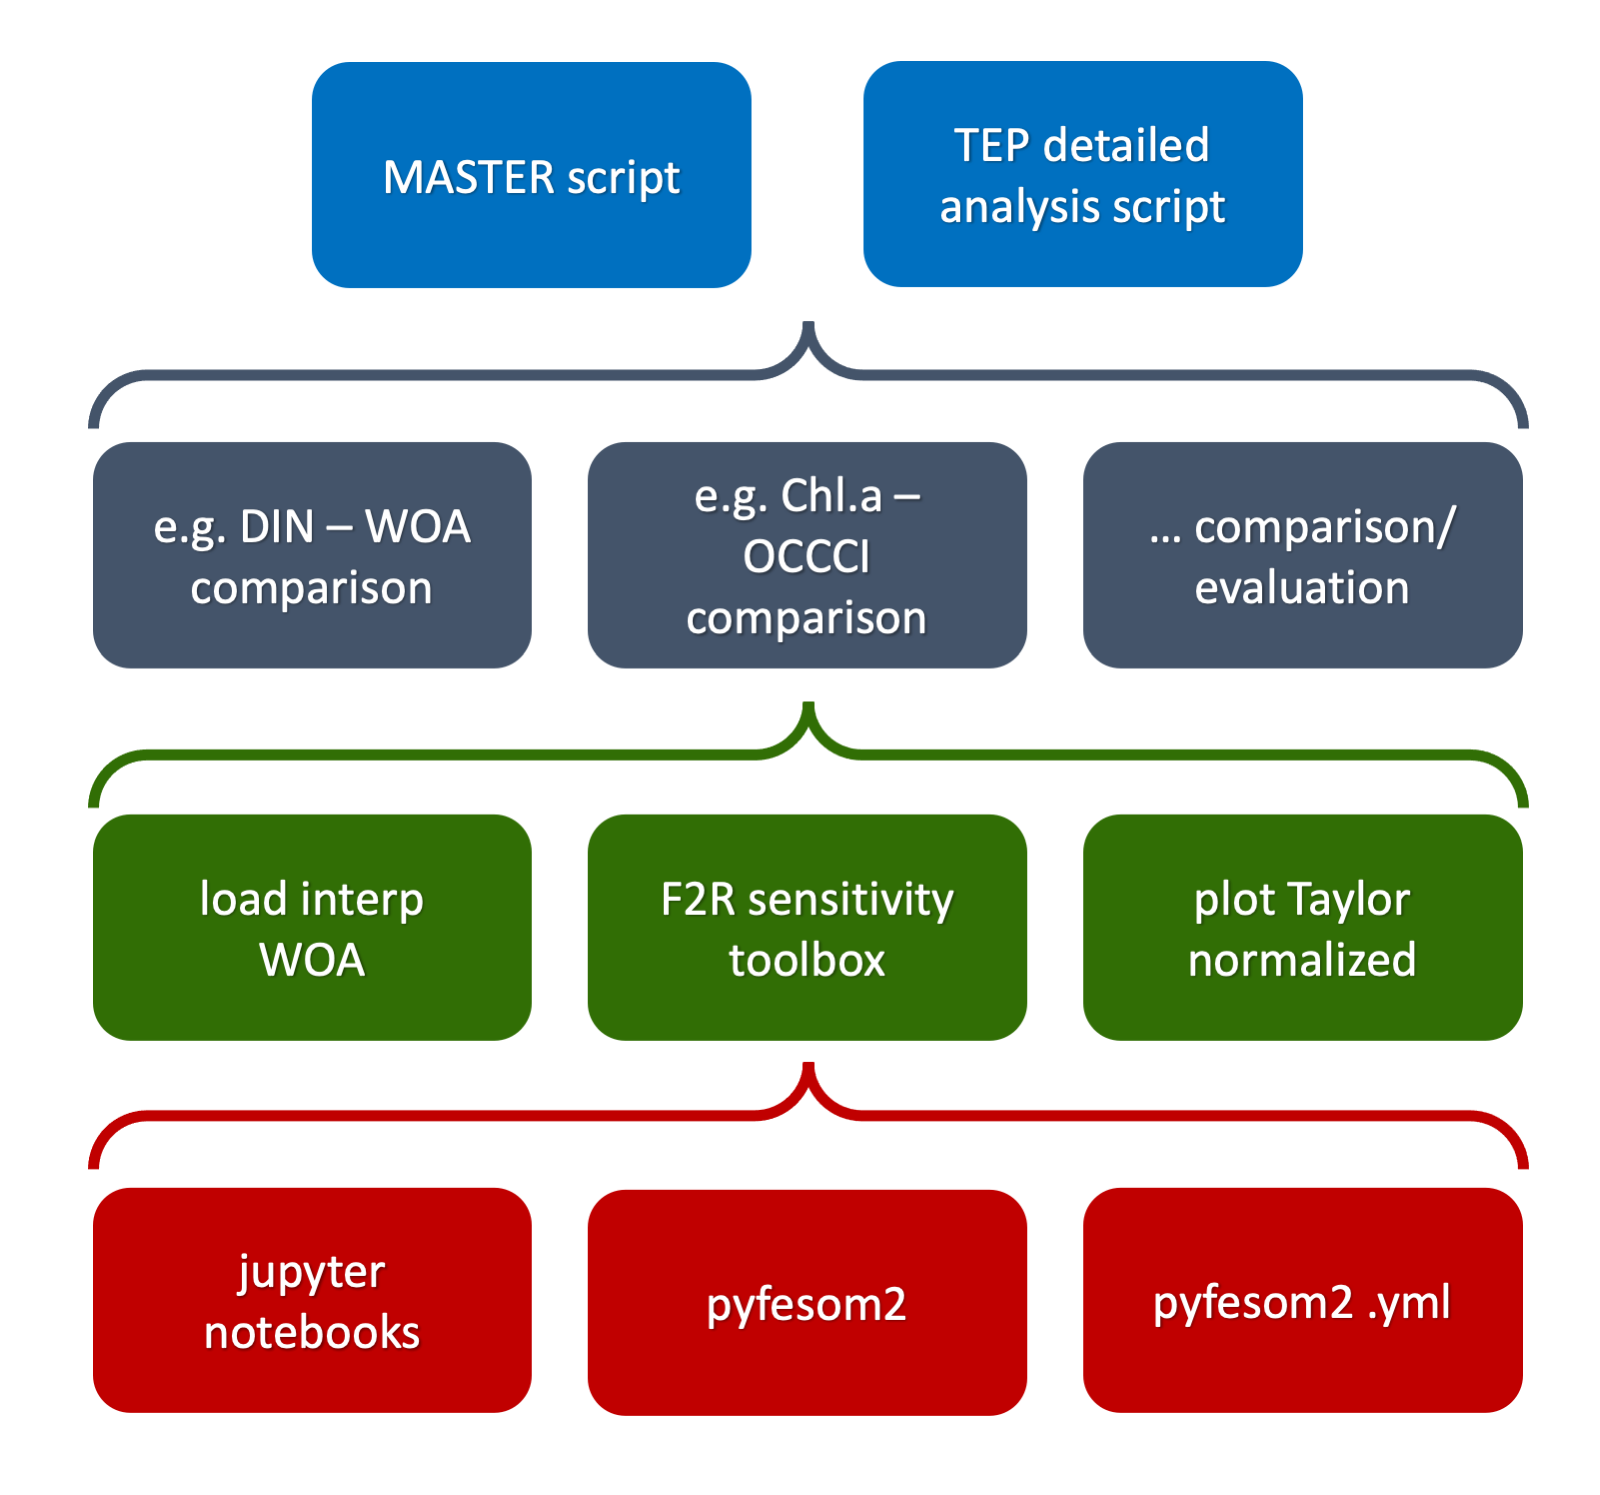

In [1]:
import warnings
warnings.simplefilter("default")

from IPython import display
display.Image("./Overview_py_f2recom.png", width = 700)

# Load modules, prepare analysis

In [ ]:
# -------------------------------------------------------------------------------
# necessary modules 
import pyfesom2 as pf
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs


In [ ]:
# -------------------------------------------------------------------------------
# run specification    
runid      =  'fesom'
layerwise    = False
resultpath = '/work/ollie/mozeisin/results/f2r1.2/tep2'
meshpath = '/work/ollie/mozeisin/mesh/mesh_fesom2.0/core2_meanz'

# period of analysis 
first_year = 1948
last_year  = 1970
    
years = np.arange(first_year,last_year+1,1)
years_last10 = np.arange(last_year-10,last_year+1,1)

In [ ]:
# -------------------------------------------------------------------------------
# specification of analysis 
depth = 0
layerwise = False
mapproj = 'rob'
#Map projection. Options are Mercator (merc), Plate Carree (pc),
#North Polar Stereo (np), South Polar Stereo (sp),  Robinson (rob)
#Robinson projection is quite time consuming.

# -------------------------------------------------------------------------------
# export of analysis 
savepath = '/home/ollie/mozeisin/evaluation/mo_files/'
savefig = False
htmlname = 'test.html'
htmlpath = '/home/ollie/mozeisin/evaluation/mo_files/html/'

In [ ]:
# -------------------------------------------------------------------------------
# mesh initialization 
mesh = pf.load_mesh(meshpath)

In [ ]:
# list of depth levels
# note: concentrations are defined at mid-level depth!
mesh.zlev

# 1) Example: Use of pyfesom2 tools for simple plotting

## Map of total Diatom NPP 

In [ ]:
NCfesom = resultpath + '/NPPd.fesom.1948.nc'
!ncdump -h $NCfesom

In [ ]:
label='Diatom NPP {0}-{1}'.format(last_year-10,last_year)
units = 'Mean NPP [mg C m$^{-2}$ d$^{-1}$]'

# get data
NPPd = pf.get_data(resultpath, "NPPd", 
                   years_last10,
                   mesh, runid=runid, how="mean", compute=True, silent=True)

# 12.01* data --> mmolC/m2/d to mg C/m2/d
NPPd = NPPd * 12.01

# -------------------------------------------------------------------------------
# plotting
fig = pf.plot(mesh, NPPd, mapproj = mapproj, units=units, titles=label, 
              levels = (0,1100,56),
              cmap='viridis')

# 2) Example: plotting chlorophyll

In [ ]:
from plot_Chlorophyll_FESOM_python3 import plot_Chl

label='Diatom Chlorophyll {0}-{1} at {2} m'.format(last_year-10,last_year,depth)
units = 'Chl.a [mg m$^{-3}$]' # is that really true?

# -------------------------------------------------------------------------------
fig = plot_Chl(resultpath,'DiaChl',
         years_last10,
         mesh,runid,depth,mapproj,label,units)




# 3) Example: comparison scripts

## DIN comparison with World Ocean Atlas

In [ ]:
from DIN_WOA_Comparison_python3 import DINcomp

# WOA     
ncpath                = '/work/ollie/projects/MarESys/evaluation/woa13_all_n00_01.nc'

# now test:
test = DINcomp(runid,resultpath,savepath,meshpath,ncpath,first_year,last_year,
               mapproj = 'pc')

## Comparison of Chl surface data with OCCCI

In [ ]:
from Chlsurf_OCCCI_Comparison_python3 import Chlsurf_OCCCI_comp

# OCCCI
matfileChlsurf           = '/work/ollie/projects/MarESys/evaluation/climatology_annual_chl_1deg_OCCCI_2012_2015.mat'

# analyze only last 10 years
test = Chlsurf_OCCCI_comp(runid,resultpath,savepath,meshpath,matfileChlsurf,
                          last_year-10,last_year,
                          mapproj=mapproj,savefig=savefig)


# 4) Example: time series scripts
## NPP and export production

In [ ]:
# time-series of NPP and export production

from NPP_TotalGlobal_python3 import NPP_TotalGlobal

test = NPP_TotalGlobal(runid,resultpath,savepath,meshpath,first_year,last_year,savefig=savefig)

### export production --> detritus sinking out of 100 m depth       


# 5) Example: monthly output processing
## Load sea ice data and calculate seasonal cycle

In [ ]:
from F2R_sensitivity_toolbox import var_monthly

aIce_monthly = var_monthly(resultpath, 'a_ice', years_last10, mesh, only2D=True)

aIce_monthly.seasonalcycle()

In [ ]:
### interpolation

# regular grid
lat         = np.arange(-89.5,90.,1.)
lon         = np.arange(-179.5,180.,1.)
latdic, londic = np.meshgrid(lat, lon)

# -------------------------------------------------------------------------------
# July
aIce_monthly_interp_JUL = pf.fesom2regular(data = aIce_monthly.data_seasonalcycle[6,:],
                                           mesh = mesh,lons = londic,lats = latdic)

# September
aIce_monthly_interp_SEP = pf.fesom2regular(data = aIce_monthly.data_seasonalcycle[8,:],
                                           mesh = mesh,lons = londic,lats = latdic)



In [ ]:
### plotting
from F2R_sensitivity_toolbox import mygrid

units = 'Ice concentration [%] \nMean of {0}-{1}'.format(years_last10[0],years_last10[-1])
cmap = 'BuPu'

# North Polar Stereo Projection
fig = plt.figure(figsize=(15,10))
plot_extent = [-180, 180, 70, 90]

# -------------------------------------------------------------------------------
# July
ax1 = plt.subplot(1,2,1,projection = ccrs.NorthPolarStereo())
m1 = ax1.pcolormesh(londic, latdic, aIce_monthly_interp_JUL, 
    transform = ccrs.PlateCarree(),
    cmap=cmap)

mygrid(ax1,grid=True)

ax1.set_extent(plot_extent, crs=ccrs.PlateCarree())
ax1.set_title('July',fontsize=20)

# -------------------------------------------------------------------------------
# September
ax2 = plt.subplot(1,2,2,projection = ccrs.NorthPolarStereo())
m2 = ax2.pcolormesh(londic, latdic, aIce_monthly_interp_SEP, 
    transform = ccrs.PlateCarree(),
    cmap=cmap)

mygrid(ax2,grid=True)

ax2.set_extent(plot_extent, crs=ccrs.PlateCarree())
ax2.set_title('September',fontsize=20)

# -------------------------------------------------------------------------------
# colorbar
cbar = fig.colorbar(m1, ax=[ax1,ax2],orientation = 'horizontal',
                    fraction=0.1, pad=0.05, shrink = 0.8) 
cbar.set_label(units, fontsize=20)
cbar.ax.tick_params(labelsize=20)

plt.tight_layout()

